In [29]:

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

RANDOM_SEED = 42
CV_FOLDS = 5
N_ITER_TUNING = 50

In [30]:
# Load dataset and filter for wildfire-exposed regions with complete data
df = pd.read_csv("/Users/nzaramakouadio/Documents/Duke Classes/Spring 2025/ML/IDS705_MachineLearning_Project/10_Data_Clean/xgboost_data.csv")



In [31]:
df.isna().sum()

Median_Household_Income                        26
Total_Population                                0
PRICE                                           0
Avg_Household_Size                              0
Gini_Index                                      0
ZIP_CODE                                        0
YEAR                                            0
Employment_Rate                                 7
Below_Poverty_Rate                              0
Rate_College_or_Higher                          0
Black_Portion                                   0
White_Portion                                   0
American_Indian_and_Alaska_Native_Portion       0
Asian_Portion                                   0
NUM_FIRES                                       0
TOTAL_ACRES_BURNED_IN_ZIP                       0
AVG_FIRE_DURATION_DAYS                          0
MAX_PCT_ZIP_BURNED                              0
ANY_MAJOR_FIRE                                  0
FIRE_EXPOSED                                    0


In [32]:
# Remove Na's or else linear regression below won't work

df.dropna(subset=[
    'ROLLING_1yr_PRICE_CHANGE', 
    'HOME_PRICE_LAG1', 
    'PRICE_CHANGE_LAG1', 
    'PRICE_CHANGE_DIFF'
], inplace=True)


# This is the xgboost model that answers how to predict price for zip codes exposed to fire and zip codes not exposed to fire

In [33]:
# Step 1: Predict price change using only historical price info
X_price = df[['HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1']]
y = df['PCT_PRICE_CHANGE (%)']

price_model = LinearRegression()
price_model.fit(X_price, y)
df['price_pred'] = price_model.predict(X_price)
df['residual'] = y - df['price_pred']


In [34]:

# Step 2: Use fire-related variables to predict the residual
fire_features = [
    'NUM_FIRES',
    'TOTAL_ACRES_BURNED_IN_ZIP',
    'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED',
    'ANY_MAJOR_FIRE',
    'FIRE_EXPOSED',
    'PREV_MAX_PCT_ZIP_BURNED',
    'FIRE_LAST_YEAR',
    'FIRE_SHOCK',   
]

X_resid = df[fire_features]
y_resid = df['residual']

# Train XGBoost on residuals
tscv = TimeSeriesSplit(n_splits=CV_FOLDS)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED)

param_dist = {
    'n_estimators': randint(100, 800),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_lambda': uniform(0.5, 2.0),
    'reg_alpha': uniform(0, 1.0)
}

search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist,
    n_iter=N_ITER_TUNING, scoring='r2', cv=tscv,
    random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)
search.fit(X_resid, y_resid)
best_model = search.best_estimator_
df['resid_pred'] = best_model.predict(X_resid)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


Combined Model Evaluation:
RMSE: 11.1348
MAE : 5.8899
R²  : 0.0541


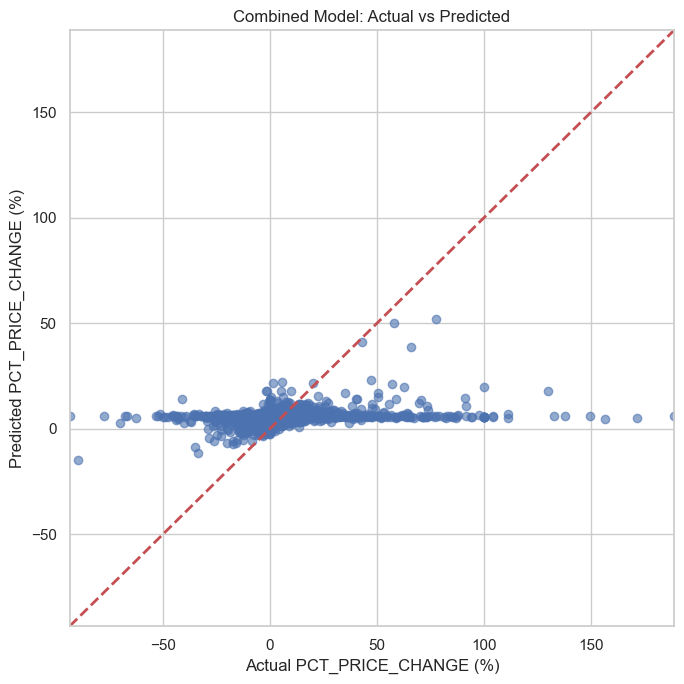

In [35]:

# Final prediction = historical price model + residual prediction
df['final_pred'] = df['price_pred'] + df['resid_pred']

# Evaluate final model
rmse = np.sqrt(mean_squared_error(df['PCT_PRICE_CHANGE (%)'], df['final_pred']))
mae = mean_absolute_error(df['PCT_PRICE_CHANGE (%)'], df['final_pred'])
r2 = r2_score(df['PCT_PRICE_CHANGE (%)'], df['final_pred'])

print("Combined Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# Scatter plot of predicted vs actual
plt.figure(figsize=(7, 7))
plt.scatter(df['PCT_PRICE_CHANGE (%)'], df['final_pred'], alpha=0.6)
min_v = min(df['PCT_PRICE_CHANGE (%)'].min(), df['final_pred'].min())
max_v = max(df['PCT_PRICE_CHANGE (%)'].max(), df['final_pred'].max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=2)
plt.xlabel("Actual PCT_PRICE_CHANGE (%)")
plt.ylabel("Predicted PCT_PRICE_CHANGE (%)")
plt.title("Combined Model: Actual vs Predicted")
plt.grid(True)
plt.xlim(min_v, max_v)
plt.ylim(min_v, max_v)
plt.tight_layout()
plt.show()

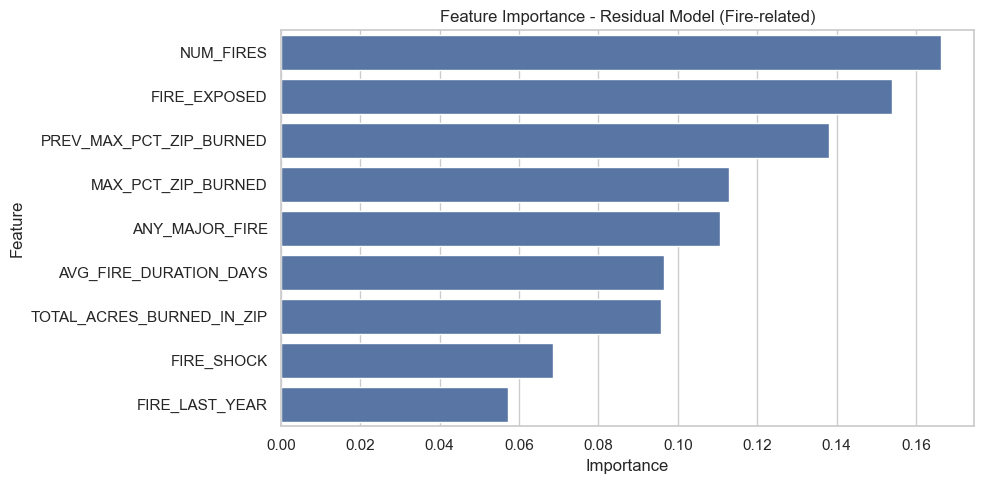

In [36]:

# Show feature importance from XGBoost residual model
importances = best_model.feature_importances_
fi = pd.DataFrame({'Feature': fire_features, 'Importance': importances})
fi = fi.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=fi)
plt.title("Feature Importance - Residual Model (Fire-related)")
plt.tight_layout()
plt.show()

# This is the classification model to predict if price goes below or above the median for only zip codes affected by fire

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Step 1: Subset only ZIP-year rows exposed to wildfire
df_fire = df[df['FIRE_EXPOSED'] == 1].copy()

# Step 2: Create binary target — whether price change was above or below median
median_change = df_fire['PCT_PRICE_CHANGE (%)'].median()
df_fire['TARGET_LABEL'] = (df_fire['PCT_PRICE_CHANGE (%)'] > median_change).astype(int)

# Step 3: Define features for classification model
features = [
    'HOME_PRICE_LAG1',
    'PRICE_CHANGE_LAG1',
    'PRICE_CHANGE_DIFF',
    'FIRE_SHOCK',
    'FIRE_LAST_YEAR',
    'TOTAL_ACRES_BURNED_IN_ZIP',
    'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED',
    'NUM_FIRES',
    'ANY_MAJOR_FIRE'
]

X = df_fire[features]
y = df_fire['TARGET_LABEL']

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 5: Train XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Step 6: Make predictions and evaluate
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
x


              precision    recall  f1-score   support

           0       0.91      0.90      0.91       143
           1       0.89      0.90      0.90       132

    accuracy                           0.90       275
   macro avg       0.90      0.90      0.90       275
weighted avg       0.90      0.90      0.90       275

[[129  14]
 [ 13 119]]


NameError: name 'x' is not defined